# 1. 환경 설정 및 라이브러리 설치

In [2]:
# 1. 환경 설정 및 라이브러리 임포트

# 1. 필수 라이브러리 설치 (버전 지정을 제거하여 Colab 환경에 맞춰 최신 버전을 사용하게 합니다.)
!pip install transformers
!pip install torch # Colab이 현재 지원하는 최신 버전을 설치합니다.
!pip install seqeval pytorch-crf tqdm

# 2. KoBERT 모델과 토크나이저를 사용하기 위한 라이브러리 설치
# KoBERT 토크나이저를 'transformers' 패키지에서 바로 로드할 수 있게 하는 패키지
!pip install sentencepiece
!pip install tokenizers # tokenizers 빌드 오류 방지를 위해 명시적 설치

# 3. 한글 폰트 설정 (시각화를 위해)
!sudo apt-get install -y fonts-nanum > /dev/null
!sudo fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib

print("⚠️ 라이브러리 설치 완료. 다음 셀 실행 전에 '런타임' -> '런타임 다시 시작'을 반드시 해주세요.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=59e9924d6291dfc5eface1ec40ecd4644dd2c7245666d0281d9cd53f3656e348
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
⚠️ 라이브러리 설치 완료. 다음 셀 실행 전에 '런타임' -> '런타임 다시 시작'을 반드시 해주세요.


# 2. 라이브러리 및 데이터 로드, BIO 태깅 변환

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertModel, AutoTokenizer, AutoModel # AutoTokenizer, AutoModel 로드 확인
from torch.nn.utils.rnn import pad_sequence
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

# ----------------- 데이터 로드 -----------------
# Assignment 4에서 생성한 1000개 데이터셋 경로 설정
DATA_PATH = '/slack_calendar_data.csv'
# Colab 실행 환경에 맞게 경로를 수정해주세요. (예: 'X11/data/slack_calendar_data.csv')
# 절대 경로를 사용하는 것이 가장 안전합니다. 예: DATA_PATH = '/content/X11/data/slack_calendar_data.csv'

try:
    df = pd.read_csv(DATA_PATH, encoding='utf-8')
    print(f"✅ 데이터 로드 성공! 총 {len(df)}개 행.")
except FileNotFoundError:
    print(f"❌ 오류: 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요: {DATA_PATH}")
    # 파일 로드 실패 시 빈 DataFrame을 반환하여 다음 셀 실행 중단을 방지합니다.
    df = pd.DataFrame({'message': [], 'title': [], 'location': [], 'date_info_parsed': []})
    print("⚠️ 데이터 로드 실패로 분석 및 학습은 불가능합니다. 파일 경로를 수정 후 다시 실행하세요.")

# 'location' NaN 값을 모델이 학습할 수 있는 '-' 문자열로 변환
df['location'] = df['location'].fillna('-')

# ----------------- BIO 태깅 시스템 정의 -----------------
# B: Begin, I: Inside, O: Other
# SUB: Subject, DT: Date/Time, LOC: Location
labels = ['O', 'B-SUB', 'I-SUB', 'B-DT', 'I-DT', 'B-LOC', 'I-LOC']
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for i, label in enumerate(labels)}
NUM_LABELS = len(labels)

# KoBERT 토크나이저 로드 (Hugging Face의 안정적인 경로 사용)
KOBERT_MODEL_NAME = "skt/kobert-base-v1"
tokenizer = AutoTokenizer.from_pretrained(KOBERT_MODEL_NAME)

# ----------------- 전처리 함수 정의: 메시지를 BIO 태깅 시퀀스로 변환 -----------------
def get_bio_tags(message, title, location):
    # 1. 메시지 토큰화 (KoBERT 기준)
    tokens = tokenizer.tokenize(message)
    tags = ['O'] * len(tokens)

    # 2. BIO 태깅을 위한 엔티티 토큰화
    entity_map = {}
    if title != '-': entity_map['SUB'] = tokenizer.tokenize(title)
    if location != '-': entity_map['LOC'] = tokenizer.tokenize(location)

    # 3. SUB / LOC 태깅: 정확히 일치하는 부분 찾기
    for entity_tag, entity_tokens in entity_map.items():
        if not entity_tokens: continue # 빈 엔티티 토큰화 결과는 건너뜀

        for i in range(len(tokens) - len(entity_tokens) + 1):
            if tokens[i:i+len(entity_tokens)] == entity_tokens:
                tags[i] = f'B-{entity_tag}'
                for j in range(1, len(entity_tokens)):
                    tags[i+j] = f'I-{entity_tag}'
                break

    # 4. 날짜/시간 (DT) 태깅 (간단한 룰 기반 태깅):
    # 이미 SUB/LOC에 태깅되지 않은 토큰 중 시간/날짜 관련 키워드 태깅
    time_keywords = ['시', '분', '월', '일', '주', '내일', '모레', '오늘', '오전', '오후', '저녁']
    for i, token in enumerate(tokens):
        if tags[i] == 'O':
            # 토큰이 시간/날짜 키워드를 포함하는지 확인
            if any(keyword in token for keyword in time_keywords):
                tags[i] = 'B-DT'

    # 5. 토큰 개수와 태그 개수가 일치하는지 최종 확인
    if len(tokens) != len(tags):
        print(f"경고: 토큰({len(tokens)})과 태그({len(tags)}) 개수 불일치. O 태그로 채움.")
        tags = ['O'] * len(tokens)

    return tokens, [label_to_id[tag] for tag in tags]

# ----------------- 데이터셋 변환 및 분할 -----------------
tokenized_data = []
if not df.empty:
    for index, row in df.iterrows():
        tokens, tag_ids = get_bio_tags(row['message'], row['title'], row['location'])

        # [CLS], [SEP] 토큰 추가 및 최대 길이 64로 제한
        input_ids = tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])
        tag_ids = [label_to_id['O']] + tag_ids + [label_to_id['O']]

        # 최대 길이 제한 (64)
        if len(input_ids) > 64:
            input_ids = input_ids[:63] + [input_ids[-1]]
            tag_ids = tag_ids[:63] + [tag_ids[-1]]

        tokenized_data.append({
            'input_ids': torch.tensor(input_ids),
            'labels': torch.tensor(tag_ids)
        })

# Train/Validation/Test 분할 (80:10:10)
train_data, temp_data = train_test_split(tokenized_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"총 데이터 수: {len(tokenized_data)}개")
print(f"Train Set: {len(train_data)}개, Validation Set: {len(val_data)}개, Test Set: {len(test_data)}개")
print(f"사용된 레이블: {labels}")

✅ 데이터 로드 성공! 총 1000개 행.
총 데이터 수: 1000개
Train Set: 800개, Validation Set: 100개, Test Set: 100개
사용된 레이블: ['O', 'B-SUB', 'I-SUB', 'B-DT', 'I-DT', 'B-LOC', 'I-LOC']


# 3. PyTorch Dataset 및 DataLoader 정의

In [4]:
# 3. PyTorch Dataset 및 DataLoader 정의

MAX_LEN = 64 # KoBERT 입력 최대 길이

class ScheduleDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    # Padding을 위한 함수 (KoBERT의 [PAD] 토큰 ID: 1)

    # input_ids와 labels를 분리
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]

    # 패딩 마스크 생성 (0이 패딩 위치)
    attention_mask = [torch.ones_like(ids) for ids in input_ids]

    # 패딩 적용
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.vocab['[PAD]'])
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=label_to_id['O'])
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids_padded,
        'labels': labels_padded,
        'attention_mask': attention_mask_padded
    }

# DataLoader 설정
BATCH_SIZE = 32
train_dataloader = DataLoader(ScheduleDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(ScheduleDataset(val_data), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# 4. 모델 설계: KoBERT-CRF 구현

In [5]:
# 4. 모델 설계: KoBERT-CRF 구현

from torch import nn
from torch.optim import AdamW
from torchcrf import CRF

# ----------------- KoBERT + CRF 모델 클래스 정의 -----------------
class KoBERTNerModel(nn.Module):
    def __init__(self, num_labels):
        super(KoBERTNerModel, self).__init__()
        # 1. KoBERT 인코더 로드
        self.bert = BertModel.from_pretrained('skt/kobert-base-v1')
        self.dropout = nn.Dropout(0.1)
        # 2. 출력 레이블 수(NUM_LABELS)에 맞는 Linear Layer
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        # 3. CRF 레이어 (Loss 계산 및 최적 경로 디코딩 담당)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        # KoBERT 인코딩: [batch_size, seq_len, hidden_size]
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]

        # Dropout 및 Classification Layer 통과: [batch_size, seq_len, num_labels]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        # Labels가 제공되면 Loss 계산 (CRF는 negative log likelihood를 사용)
        if labels is not None:
            # mask: attention_mask를 boolean 형태로 변환
            mask = attention_mask.bool()
            # crf.forward(logits, tags, mask): log-likelihood of the true sequence given the emission scores
            # loss = -log-likelihood
            loss = -self.crf(logits, labels, mask=mask, reduction='mean')
            return loss, logits
        else:
            # Labels가 없으면 최적 경로 예측 (Viterbi decoding)
            # crf.decode(emissions, mask): returns the best sequence of tags
            mask = attention_mask.bool()
            tags = self.crf.decode(logits, mask=mask)
            return tags, logits

# ----------------- 모델 인스턴스화 -----------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KoBERTNerModel(NUM_LABELS).to(device)

# Optimizer 및 Learning Rate Scheduler 설정
OPTIMIZER = AdamW(model.parameters(), lr=5e-5)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

# 5. 학습 및 검증 루프 (Training & Validation Loop)

In [6]:
# 5. 학습 및 검증 루프 (Training & Validation Loop)

# 성능 지표 계산 함수 (BIO 태그에 특화된 seqeval 사용)
def calculate_metrics(predictions, true_labels, attention_mask):
    # [CLS], [SEP], [PAD] 토큰을 제외하고 평가

    # 예측 및 실제 레이블을 List[List[str]] 형태로 변환
    true_tags = []
    pred_tags = []

    for pred, label, mask in zip(predictions, true_labels, attention_mask):
        true_sentence_tags = []
        pred_sentence_tags = []

        for p, l, m in zip(pred, label, mask):
            # Attention mask가 1이고, [CLS] (인덱스 0)이나 [SEP] (인덱스 len-1)가 아닌 경우만 평가
            # KoBERT의 [CLS]는 항상 0번째, [SEP]는 문장 끝에 위치하지만, 여기서는 Mask만 확인합니다.
            if m == 1 and l != 0: # PAD 토큰(ID 0)은 제외 (CRF는 mask를 사용하지만, seqeval을 위해 직접 처리)
                true_tags_str = id_to_label[l.item()]
                pred_tags_str = id_to_label[p]

                # 'O' 태그는 seqeval 계산을 위해 포함
                true_sentence_tags.append(true_tags_str)
                pred_sentence_tags.append(pred_tags_str)

        if true_sentence_tags: # 빈 문장이 아닌 경우만 추가
            true_tags.append(true_sentence_tags)
            pred_tags.append(pred_sentence_tags)

    # seqeval을 사용하여 F1 score 계산 (Macro F1 사용)
    # seqeval은 List[List[str]] 형태를 요구합니다.
    f1 = f1_score(true_tags, pred_tags, average='macro')
    return f1


# --- 학습 설정 ---
NUM_EPOCHS = 10
BEST_MODEL_PATH = 'best_kobert_crf_model.pt'
best_val_f1 = -1.0

train_losses = []
val_f1_scores = []
epochs_ran = 0

print("\n--- 모델 학습 시작 ---")

for epoch in trange(NUM_EPOCHS, desc="Epoch"):
    model.train()
    total_train_loss = 0

    # 5.1. Train Loop
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        OPTIMIZER.zero_grad()

        loss, _ = model(input_ids, attention_mask, labels=labels)

        loss.backward()
        OPTIMIZER.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # 5.2. Validation Loop
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_masks = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            predictions, _ = model(input_ids, attention_mask, labels=None)

            # CRF decode 결과는 List[List[int]] 형태이므로 Tensor로 변환하여 저장하지 않음
            for pred_seq, true_seq, mask_seq in zip(predictions, labels, attention_mask):
                all_predictions.append(pred_seq)
                all_true_labels.append(true_seq.cpu())
                all_masks.append(mask_seq.cpu())

    # F1 Score 계산
    val_f1 = calculate_metrics(all_predictions, all_true_labels, all_masks)
    val_f1_scores.append(val_f1)
    epochs_ran += 1

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {avg_train_loss:.4f}, Val F1 Score (Macro): {val_f1:.4f}")

    # 5.3. 최적 모델 저장 (재현 가능성 확보)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"⭐ Best Model 저장 완료: {BEST_MODEL_PATH} (Val F1: {best_val_f1:.4f})")

print("\n--- 모델 학습 종료 ---")
print(f"최적 성능 Val F1 Score: {best_val_f1:.4f}")


--- 모델 학습 시작 ---


Training: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

Validation: 100%|██████████| 4/4 [00:00<00:00,  9.44it/s]


Epoch 1/10 -> Train Loss: 30.3901, Val F1 Score (Macro): 0.1143


Epoch:  10%|█         | 1/10 [00:17<02:39, 17.74s/it]

⭐ Best Model 저장 완료: best_kobert_crf_model.pt (Val F1: 0.1143)



Training: 100%|██████████| 25/25 [00:08<00:00,  2.82it/s]

Validation: 100%|██████████| 4/4 [00:00<00:00, 10.17it/s]


Epoch 2/10 -> Train Loss: 11.1024, Val F1 Score (Macro): 0.5635


Epoch:  20%|██        | 2/10 [00:28<01:50, 13.76s/it]

⭐ Best Model 저장 완료: best_kobert_crf_model.pt (Val F1: 0.5635)



Training: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]

Validation: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


Epoch 3/10 -> Train Loss: 3.9754, Val F1 Score (Macro): 0.7815


Epoch:  30%|███       | 3/10 [00:38<01:24, 12.10s/it]

⭐ Best Model 저장 완료: best_kobert_crf_model.pt (Val F1: 0.7815)



Training: 100%|██████████| 25/25 [00:08<00:00,  2.79it/s]

Validation: 100%|██████████| 4/4 [00:00<00:00,  8.50it/s]


Epoch 4/10 -> Train Loss: 2.2033, Val F1 Score (Macro): 0.8483


Epoch:  40%|████      | 4/10 [00:54<01:21, 13.65s/it]

⭐ Best Model 저장 완료: best_kobert_crf_model.pt (Val F1: 0.8483)



Training: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]

Validation: 100%|██████████| 4/4 [00:00<00:00,  9.93it/s]


Epoch 5/10 -> Train Loss: 2.0708, Val F1 Score (Macro): 0.9701


Epoch:  50%|█████     | 5/10 [01:05<01:03, 12.61s/it]

⭐ Best Model 저장 완료: best_kobert_crf_model.pt (Val F1: 0.9701)



Training: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]

Validation: 100%|██████████| 4/4 [00:00<00:00,  9.67it/s]


Epoch 6/10 -> Train Loss: 1.5586, Val F1 Score (Macro): 0.9737


Epoch:  60%|██████    | 6/10 [01:16<00:48, 12.06s/it]

⭐ Best Model 저장 완료: best_kobert_crf_model.pt (Val F1: 0.9737)



Training: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

Epoch:  70%|███████   | 7/10 [01:26<00:33, 11.31s/it]

Epoch 7/10 -> Train Loss: 1.0306, Val F1 Score (Macro): 0.9474



Training: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

Validation: 100%|██████████| 4/4 [00:00<00:00,  9.10it/s]


Epoch 8/10 -> Train Loss: 0.7179, Val F1 Score (Macro): 1.0000


Epoch:  80%|████████  | 8/10 [01:37<00:22, 11.17s/it]

⭐ Best Model 저장 완료: best_kobert_crf_model.pt (Val F1: 1.0000)



Training: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

Epoch:  90%|█████████ | 9/10 [01:47<00:10, 10.76s/it]

Epoch 9/10 -> Train Loss: 0.6415, Val F1 Score (Macro): 1.0000



Training: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]

Epoch: 100%|██████████| 10/10 [01:57<00:00, 11.72s/it]

Epoch 10/10 -> Train Loss: 0.5130, Val F1 Score (Macro): 1.0000

--- 모델 학습 종료 ---
최적 성능 Val F1 Score: 1.0000


# 6. 학습 곡선 시각화

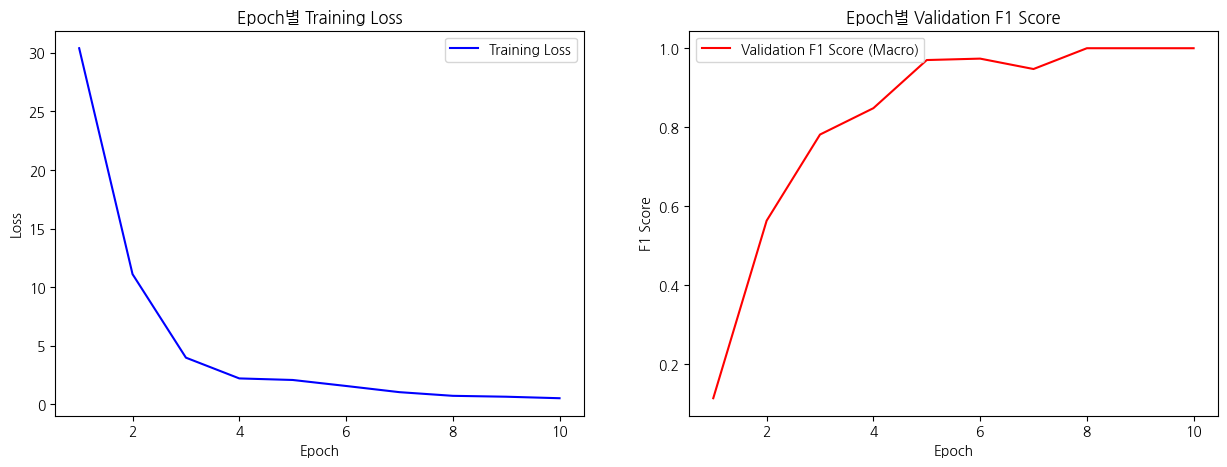


✅ 모델 가중치가 'best_kobert_crf_model.pt'에 저장되어 재현성이 확보되었습니다.
다음 단계는 이 모델을 Google Drive/HuggingFace에 업로드하고, evaluation.ipynb를 작성하는 것입니다.


In [7]:
# 6. 학습 곡선 시각화

# Matplotlib 한글 폰트 설정 (이 셀에서 폰트 문제 재발 시 재실행)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

epochs = range(1, epochs_ran + 1)

plt.figure(figsize=(15, 5))

# Loss 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.title('Epoch별 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# F1 Score 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1_scores, 'r', label='Validation F1 Score (Macro)')
plt.title('Epoch별 Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.show()

print(f"\n✅ 모델 가중치가 '{BEST_MODEL_PATH}'에 저장되어 재현성이 확보되었습니다.")
print("다음 단계는 이 모델을 Google Drive/HuggingFace에 업로드하고, evaluation.ipynb를 작성하는 것입니다.")